In [8]:
import datetime
import numpy as np
import scipy.ndimage
import os

from random import sample

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator

import keras.utils

In [2]:
batch_size = 4
num_epochs = 50

max_rotation_angle = 10
max_shift = 0.1
max_zoom = 0.1

In [3]:
ultrasound_fullname = 'numpy_data/Stacked Arrays/Training/stacked_image_64.npy'
segmentation_fullname = 'numpy_data/Stacked Arrays/Training/stacked_segmentation_64.npy'

ultrasound_data = np.load(ultrasound_fullname)
segmentation_data = np.load(segmentation_fullname)

ultrasound_size = ultrasound_data.shape[1:4]

num_ultrasound = ultrasound_data.shape[0]
num_segmentation = segmentation_data.shape[0]

print("\nFound {} ultrasound images and {} segmentations".format(num_ultrasound, num_segmentation))
print("Ultrasound size: {}".format(ultrasound_size))


Found 24 ultrasound images and 24 segmentations
Ultrasound size: (64, 64, 64)


In [4]:
test_ultrasound_fullname = 'numpy_data/Stacked Arrays/Test/test_image_64.npy'
test_segmentation_fullname = 'numpy_data/Stacked Arrays/Test/test_segmentation_64.npy'

print("Reading test ultrasound from: {}".format(test_ultrasound_fullname))
print("Reading test segmentation from : {}".format(test_segmentation_fullname))

test_ultrasound_data = np.load(test_ultrasound_fullname)
test_segmentation_data = np.load(test_segmentation_fullname)

num_test_ultrasound = test_ultrasound_data.shape[0]
num_test_segmentation = test_segmentation_data.shape[0]

print("\nFound {} test ultrasound images and {} segmentations".format(num_test_ultrasound, num_test_segmentation))

Reading test ultrasound from: numpy_data/Stacked Arrays/Test/test_image_64.npy
Reading test segmentation from : numpy_data/Stacked Arrays/Test/test_segmentation_64.npy

Found 6 test ultrasound images and 6 segmentations


In [5]:
# Write some data samples for check

num_export = 3

indices = [i for i in range(num_ultrasound)]
sample_indices = sample(indices, num_export)

print("Exporting ultrasound samples: {}".format(sample_indices))

for i in range(num_export):
    print("Printing image #{:02d}".format(i))
    np.save("sample_ultrasound_{:02d}".format(i), ultrasound_data[sample_indices[i], :, :, :, 0])
    np.save("sample_segmentation_{:02d}".format(i), segmentation_data[sample_indices[i], :, :, :, 0])

Exporting ultrasound samples: [14, 13, 10]
Printing image #00
Printing image #01
Printing image #02


In [6]:
# Multi-slice view code extracted and adapted from:
# https://www.datacamp.com/community/tutorials/matplotlib-3d-volumetric-data

import matplotlib.pyplot as plt

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

In [9]:
# Batch Generator

class UltrasoundSegmentationBatchGenerator(keras.utils.Sequence):
    
    def __init__(self,
                 x_set,
                 y_set,
                 batch_size,
                 image_dimensions,
                 shuffle=True,
                 n_channels=1,
                 n_classes=2):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dimensions = image_dimensions
        print("Generator created for image size: {}".format(self.image_dimensions))
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.number_of_images = self.x.shape[0]
        self.indices = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indices)
            
    def __len__(self):
        return int(np.floor(self.number_of_images / self.batch_size))
    
    def on_epoch_end(self):
        self.indices = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indices)
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dimensions, self.n_channels))
        y = np.empty((self.batch_size, *self.image_dimensions))
        
        for i in range(self.batch_size):
            flip_flag = np.random.randint(2)
            if flip_flag == 1:
                x[i,:,:,:,:] = np.flip(self.x[batch_indices[i],:,:,:,:], axis=0)
                y[i,:,:,:]   = np.flip(self.y[batch_indices[i],:,:,:,0], axis=0)
            else:
                x[i,:,:,:,:] = self.x[batch_indices[i],:,:,:,:]
                y[i,:,:,:]   = self.y[batch_indices[i],:,:,:,0]
            
        # Rotations
        
        x_rot = np.copy(x)
        y_rot = np.copy(y)
            
        for i in range(self.batch_size):
            angle_x = np.random.randint(-max_rotation_angle, max_rotation_angle)
            x_rot[i,:,:,:,:] = scipy.ndimage.interpolation.rotate(
                x[i,:,:,:,:], angle_x, (1,2), False, mode="constant", cval=0, order=0)
            y_rot[i,:,:,:] = scipy.ndimage.interpolation.rotate(
                y[i,:,:,:], angle_x, (1,2), False, mode="constant", cval=0, order=0)
        
        # angle_y = np.random.randint(-max_rotation_angle, max_rotation_angle)
        # x_rot = scipy.ndimage.interpolation.rotate(x, angle_y, (0,2), False, mode="constant", cval=0, order=0)
        # y_rot = scipy.ndimage.interpolation.rotate(y, angle_y, (0,2), False, mode="constant", cval=0, order=0)
        
        # angle_z = np.random.randint(-max_rotation_angle, max_rotation_angle)
        # x_rot = scipy.ndimage.interpolation.rotate(x, angle_z, (0,1), False, mode="constant", cval=0, order=0)
        # y_rot = scipy.ndimage.interpolation.rotate(y, angle_z, (0,1), False, mode="constant", cval=0, order=0)
        
        # shift
        
        shift = np.random.uniform(-max_shift, max_shift, size=5)
        shift[0] = 0.0
        shift[4] = 0.0
        # x_shift = scipy.ndimage.interpolation.shift(x_rot, shift)
        # y_shift = scipy.ndimage.interpolation.shift(y_rot, shift[:4])
        
        # make sure values are between 0 and 1
        
        # x_aug = np.clip(x_shift, 0.0, 1.0)
        # y_aug = np.clip(y_shift, 0.0, 1.0)
        
        x_aug = np.clip(x_rot, 0.0, 1.0)
        y_aug = np.clip(y_rot, 0.0, 1.0)
        
        # convert segmentation to one-hot encoding
        
        y_onehot = keras.utils.to_categorical(y_aug, self.n_classes)

        return x_aug, y_onehot

In [10]:
# Test input generator

training_generator = UltrasoundSegmentationBatchGenerator(
    ultrasound_data,
    segmentation_data,
    batch_size,
    image_dimensions=(ultrasound_size))

bx, by = training_generator.__getitem__(0)

print("x shape: {} --- min: {} --- max: {}".format(bx.shape, bx.min(), bx.max()))
print("y shape: {} --- min: {} --- max: {}".format(by.shape, by.min(), by.max()))

Generator created for image size: (64, 64, 64)
x shape: (4, 64, 64, 64, 1) --- min: 0.0 --- max: 0.9808208497747307
y shape: (4, 64, 64, 64, 2) --- min: 0.0 --- max: 1.0


In [11]:
for i in range(batch_size):
    print("Printing image: bx_{:02d}".format(i))
    np.save("bx_{:02d}".format(i), bx[i, :, :, :, 0])
    np.save("by_{:02d}".format(i), by[i, :, :, :, 1])

Printing image: bx_00
Printing image: bx_01
Printing image: bx_02
Printing image: bx_03


In [12]:
def dilateStack(segmentation_data, iterations):
    return np.array([scipy.ndimage.binary_dilation(y, iterations=iterations) for y in segmentation_data])

width = 3
segmentation_dilated = dilateStack(segmentation_data[:, :, :, :, :], width)

In [13]:
num_classes = 2
filter_multiplier = 8

def nvidia_unet(input_size=128, num_classes=num_classes):
    input_ = Input((input_size, input_size, input_size, 1))
    skips = []
    output = input_
    c = num_classes
    
    num_layers = int(np.floor(np.log2(input_size)))
    down_conv_kernel_sizes = np.zeros([num_layers], dtype=int)
    down_filter_numbers = np.zeros([num_layers], dtype=int)
    up_conv_kernel_sizes = np.zeros([num_layers], dtype=int)
    up_filter_numbers = np.zeros([num_layers], dtype=int)
    
    for layer_index in range(num_layers):
        down_conv_kernel_sizes[layer_index] = int(3)
        down_filter_numbers[layer_index] = int( (layer_index + 1) * filter_multiplier + num_classes )
        up_conv_kernel_sizes[layer_index] = int(4)
        up_filter_numbers[layer_index] = int( (num_layers - layer_index - 1) * filter_multiplier + num_classes )
    
    print("Number of layers:       {}".format(num_layers))
    print("Filters in layers down: {}".format(down_filter_numbers))
    print("Filters in layers up:   {}".format(up_filter_numbers))
    
    for shape, filters in zip(down_conv_kernel_sizes, down_filter_numbers):
        skips.append(output)
        output= Conv3D(filters, (shape, shape, shape), strides=2, padding="same", activation="relu")(output)
        
    for shape, filters in zip(up_conv_kernel_sizes, up_filter_numbers):
        output = keras.layers.UpSampling3D()(output)
        skip_output = skips.pop()
        output = concatenate([output, skip_output], axis=4)

        if filters != num_classes:
            output = Conv3D(filters, (shape, shape, shape), activation="relu", padding="same")(output)
            output = BatchNormalization(momentum=.9)(output)
        else:
            output = Conv3D(filters, (shape, shape, shape), activation="softmax", padding="same")(output)
    
    assert len(skips) == 0
    return Model([input_], [output])

model = nvidia_unet(ultrasound_size[0], num_classes)

# model.summary()

Number of layers:       6
Filters in layers down: [10 18 26 34 42 50]
Filters in layers up:   [42 34 26 18 10  2]
Instructions for updating:
Colocations handled automatically by placer.


In [14]:
print("Model built with {} parameters".format(model.count_params()))

Model built with 720250 parameters


In [15]:
max_learning_rate = 0.01
min_learning_rate = 0.00001

learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

model.compile(optimizer=keras.optimizers.adam(lr=max_learning_rate, decay=learning_rate_decay),
               loss= "binary_crossentropy",
               metrics=["accuracy"])

print("Learning rate decay = {}".format(learning_rate_decay))

Learning rate decay = 0.0001998


In [16]:
training_generator = UltrasoundSegmentationBatchGenerator(
    ultrasound_data,
    segmentation_data,
    batch_size,
    image_dimensions=(ultrasound_size))
test_generator = UltrasoundSegmentationBatchGenerator(
    test_ultrasound_data,
    test_segmentation_data,
    batch_size,
    image_dimensions=(ultrasound_size))

training_time_start = datetime.datetime.now()

training_log = model.fit_generator(training_generator,
                                   validation_data=test_generator,
                                   epochs=num_epochs,
                                   verbose=1)

Generator created for image size: (64, 64, 64)
Generator created for image size: (64, 64, 64)
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/50
6/6 [==============================] - 6s 994ms/step - loss: 0.7758 - acc: 0.6862 - val_loss: 0.6880 - val_acc: 0.8874
Epoch 2/50
6/6 [==============================] - 1s 158ms/step - loss: 0.1553 - acc: 0.9486 - val_loss: 0.1366 - val_acc: 0.9617
Epoch 3/50
6/6 [==============================] - 1s 223ms/step - loss: 0.0813 - acc: 0.9882 - val_loss: 0.0895 - val_acc: 0.9865
Epoch 4/50
6/6 [==============================] - 1s 223ms/step - loss: 0.0669 - acc: 0.9907 - val_loss: 1.2069 - val_acc: 0.6963
Epoch 5/50
6/6 [==============================] - 1s 222ms/step - loss: 0.0530 - acc: 0.9935 - val_loss: 0.8426 - val_acc: 0.7207
Epoch 6/50
6/6 [==============================] - 1s 220ms/step - loss: 0.0493 - acc: 0.9939 - val_loss: 0.1424 - val_acc: 0.9455


In [17]:
training_time_stop = datetime.datetime.now()
print("Training started at: {}".format(training_time_start))
print("Training stopped at: {}".format(training_time_stop))
print("Total training time: {}".format(training_time_stop-training_time_start))

Training started at: 2019-07-28 23:56:51.719128
Training stopped at: 2019-07-28 23:58:04.622331
Total training time: 0:01:12.903203


In [18]:
import datetime

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

saved_models_folder = r"j:\Data\SavedModels"
model_file_name = "model_" + timestamp + ".h5"
weights_file_path = os.path.join(saved_models_folder, model_file_name)

model.save(weights_file_path)
print("Unet Model saved to: {}".format(weights_file_path))

Unet Model saved to: j:\Data\SavedModels\model_2019-07-28_23-58-04.h5


In [19]:
trained_model = load_model(weights_file_path)
print(weights_file_path)

j:\Data\SavedModels\model_2019-07-28_23-58-04.h5


In [20]:
y_pred = trained_model.predict(test_ultrasound_data)

In [21]:
%matplotlib notebook

<IPython.core.display.Javascript object>


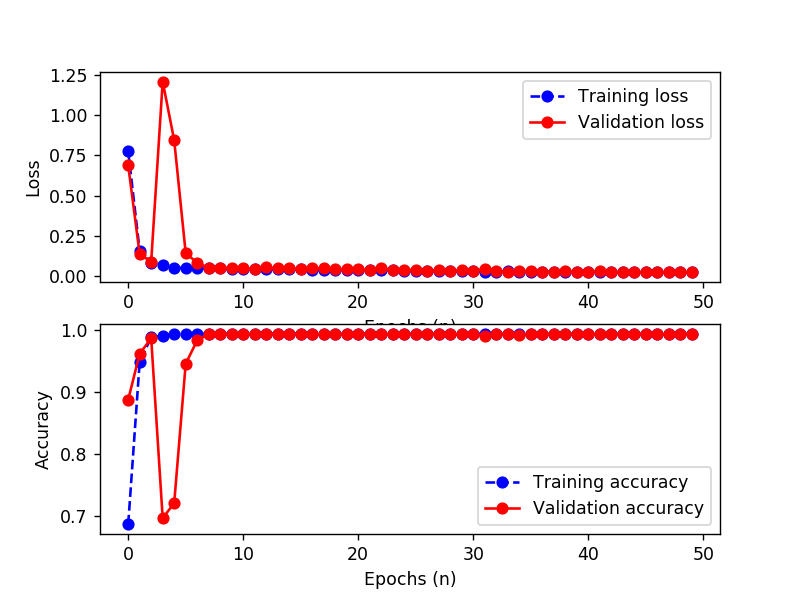

In [22]:
# Display training loss and accuracy curves over epochs

import matplotlib.pyplot as plt

plt.figure(1)

plt.subplot(211)
plt.plot(training_log.history['loss'], 'bo--')
plt.plot(training_log.history['val_loss'], 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

plt.subplot(212)
plt.plot(training_log.history['acc'], 'bo--')
plt.plot(training_log.history['val_acc'], 'ro-')
plt.ylabel('Accuracy')
plt.xlabel('Epochs (n)')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

(64, 64, 64, 1)


<IPython.core.display.Javascript object>


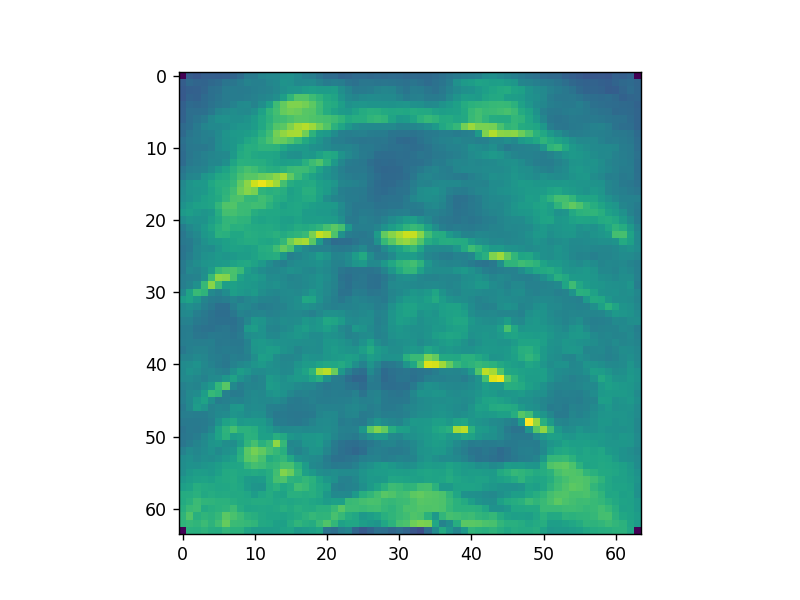

In [23]:
# ultrasound
ultrasound_img = test_ultrasound_data[0]
print(ultrasound_img.shape)
multi_slice_viewer(ultrasound_img[:, :, :, 0])

(64, 64, 64, 1)


<IPython.core.display.Javascript object>


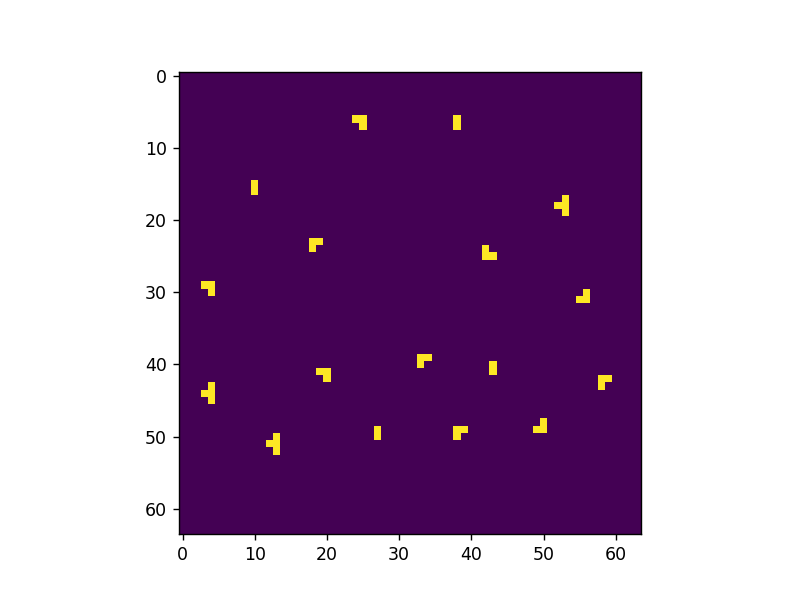

In [24]:
# Segmentation
segmentation_img = test_segmentation_data[0]
print(segmentation_img.shape)
multi_slice_viewer(segmentation_img[:, :, :, 0])

(64, 64, 64, 2)


<IPython.core.display.Javascript object>


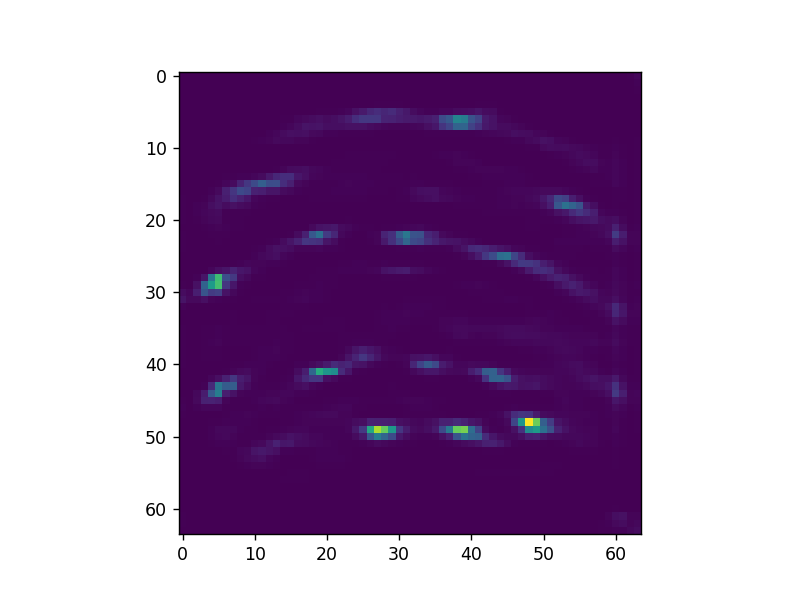

In [25]:
# Prediction
predicted_img = y_pred[0]
print(predicted_img.shape)
multi_slice_viewer(predicted_img[:, :, :, 1])

In [26]:
# Exporting volumes

export_index = 0
export_folder = r'j:\Temp'

ultrasound_fullname = os.path.join(export_folder, "ultrasound_" + str(export_index))
segmentation_fullname = os.path.join(export_folder, "segmentation_" + str(export_index))
prediction_fullname = os.path.join(export_folder, "prediction_" + str(export_index))

np.save(ultrasound_fullname, ultrasound_img[:, :, :, 0])
np.save(segmentation_fullname, segmentation_img[:, :, :, 0])
np.save(prediction_fullname, predicted_img[:, :, :, 1])

print("Sample ultrasound saved to:   {}".format(ultrasound_fullname))
print("Sample segmentation saved to: {}".format(segmentation_fullname))
print("Sample prediction saved to    {}".format(prediction_fullname))

Sample ultrasound saved to:   j:\Temp\ultrasound_0
Sample segmentation saved to: j:\Temp\segmentation_0
Sample prediction saved to    j:\Temp\prediction_0
